## Imports

In [290]:
import ast
import requests
import urllib

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

## Definitions of constants

These are the constants for the data paths.

In [291]:
DATA_FOLDER           = "../data/"
PROCESSED_DATA_FOLDER = '../processed_data/'

CHARACTER_DATASET     = DATA_FOLDER + "character.metadata.tsv"
MOVIE_DATASET         = DATA_FOLDER + "movie.metadata.tsv"
NAME_CLUSTER_DATASET  = DATA_FOLDER + "name.clusters.txt"
PLOT_DATASET          = DATA_FOLDER + "plot_summaries.txt"
TVTROPES_DATASET      = DATA_FOLDER + "tvtropes.clusters.txt"

PROCESSED_CHARACTER   = PROCESSED_DATA_FOLDER + 'character_metadata.csv'
PROCESSED_MOVIE       = PROCESSED_DATA_FOLDER + 'movie_metadata.csv'
PROCESSED_NAME        = PROCESSED_DATA_FOLDER + 'name_clusters.csv'
PROCESSED_PLOT        = PROCESSED_DATA_FOLDER + 'plot_summaries.csv'
PROCESSED_TVTROPES    = PROCESSED_DATA_FOLDER + 'tvtropes_clusters.csv'

# Step 1

### 1.1 Pre-processing the data

At first, we fetch the data from the `data` folder into pd dataframes in order to set the desired headings and to modify the type if needed.
Then we store it in `processed_data` folder in the desired .csv format.

For `movie_metadata` and `character_metadata` we modify the dates to the datetime format.

In [292]:
movie_metadata = pd.read_csv(MOVIE_DATASET, sep='\t', header=None) \
    .rename(columns={0 : 'wikipedia_movie_id',
                     1 : 'freebase_movie_id',
                     2 : 'movie_name',
                     3 : 'movie_release_date',
                     4 : 'office_revenue',
                     5 : 'runtime',
                     6 : 'languages',
                     7 : 'countries',
                     8 : 'genres'})

movie_metadata['movie_release_date'] = pd.to_datetime(movie_metadata['movie_release_date'], errors = 'coerce')

In [293]:
character_metadata = pd.read_csv(CHARACTER_DATASET, sep='\t', header=None) \
    .rename(columns={0  : 'wikipedia_movie_id',
                     1  : 'freebase_movie_id',
                     2  : 'movie_release_date',
                     3  : 'character_name',
                     4  : 'actor_birth_date',
                     5  : 'actor_gender',
                     6  : 'actor_height',
                     7  : 'actor_ethnicity',
                     8  : 'actor_name',
                     9  : 'actor_age',
                     10 : 'freebase_map_id',
                     11 : 'freebase_character_id',
                     12 : 'freebase_actor_id'})

character_metadata['movie_release_date'] = pd.to_datetime(character_metadata['movie_release_date'],          errors='coerce')
character_metadata['actor_birth_date'] =   pd.to_datetime(character_metadata['actor_birth_date'], utc=True , errors='coerce')

In [294]:
plot_summaries = pd.read_csv(PLOT_DATASET, sep='\t', header=None)\
    .rename(columns={0 :'movie_id',
                     1 : 'plot'})

In [295]:
name_clusters = pd.read_csv(NAME_CLUSTER_DATASET, sep='\t', header=None)\
    .rename(columns={0 :'character_name',
                     1 : 'freebase_map_id'})

For the `tvtropes_cluster` : we first create a raw dataframe containing the data.
Then we construct the resulting dataframe where each values of the dictionary correspond to the correct column.

In [296]:
tvtropes_cluster_raw = pd.read_csv(TVTROPES_DATASET, sep='\t', header=None)
tvtropes_cluster_raw[1] = tvtropes_cluster_raw[1].map(ast.literal_eval)
tvtropes_cluster = pd.DataFrame()

tvtropes_cluster['character_type'] = tvtropes_cluster_raw[0]
tvtropes_cluster['character_name'] = tvtropes_cluster_raw[1].map(lambda d : d['char'])
tvtropes_cluster['movie_name']     = tvtropes_cluster_raw[1].map(lambda d : d['movie'])
tvtropes_cluster['movie_id']       = tvtropes_cluster_raw[1].map(lambda d : d['id'])
tvtropes_cluster['actor_name']     = tvtropes_cluster_raw[1].map(lambda d : d['actor'])

Storing the cleaned data

In [297]:
character_metadata.to_csv(PROCESSED_CHARACTER, index=False)
movie_metadata    .to_csv(PROCESSED_MOVIE,     index=False)
plot_summaries    .to_csv(PROCESSED_PLOT,      index=False)
name_clusters     .to_csv(PROCESSED_NAME,      index=False)
tvtropes_cluster  .to_csv(PROCESSED_TVTROPES,  index=False)

### 1.2 Creating the datasets

In [298]:
#calculate the ratio of female actors for each movie

movie_gender = character_metadata.groupby(['wikipedia_movie_id', 'actor_gender']).size().unstack(fill_value=0)
movie_gender['women_ratio'] = movie_gender['F'] / (movie_gender['M'] + movie_gender['F'])
movie_gender = movie_gender['women_ratio'].reset_index()

Gender parity datasets

In [299]:
movie_information = ['wikipedia_movie_id', 'movie_release_date', 'movie_name', 'office_revenue', 'countries', 'genres']
gender_parity = pd.merge(movie_gender, movie_metadata[movie_information], on='wikipedia_movie_id').dropna()


# Step 2

Create the subsets to properly make some observations

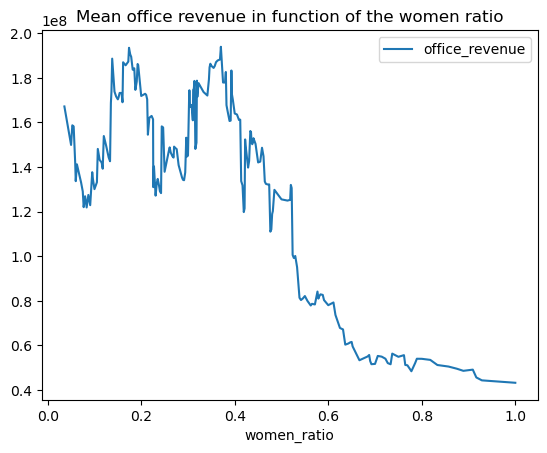

In [300]:
#first by office revenue
movie_gender_office_revenue = gender_parity[['women_ratio','office_revenue']].\
    groupby('women_ratio')\
    .agg({'office_revenue' : 'mean'})

#make a mean by rolling windows to smooth up the function
movie_gender_office_revenue = movie_gender_office_revenue.rolling(window=30, min_periods=1, center=False).mean()
movie_gender_office_revenue = movie_gender_office_revenue.iloc[2:].reset_index()

#now we can plot a graph
movie_gender_office_revenue.plot(x='women_ratio', y='office_revenue', title="Mean office revenue in function of the women ratio") ;


Auxiliary function to make a subset from a column where values are dictionaries

In [301]:
def make_subset_gender_parity(col_name) :
    subset = gender_parity[['women_ratio','wikipedia_movie_id', col_name]]

    #change the dict to list of values and explode them to get one value per row
    subset[col_name] = subset[col_name] \
        .apply(ast.literal_eval).apply(lambda x : list(x.values()))
    subset = subset.apply(pd.Series.explode)\
        .reset_index().drop(columns=['index'])

    #group by the desired column and make the mean of the women ratios
    subset = subset.groupby(col_name).agg({'women_ratio' : 'mean', 'wikipedia_movie_id' : 'count'})\
        .rename(columns={'wikipedia_movie_id' : 'count'})\
        .sort_values(by=['women_ratio']).reset_index()
    
    return subset

Plot the movie_gender per country on a world heat map.

In [302]:
#make the subset by country
movie_gender_country = make_subset_gender_parity('countries')


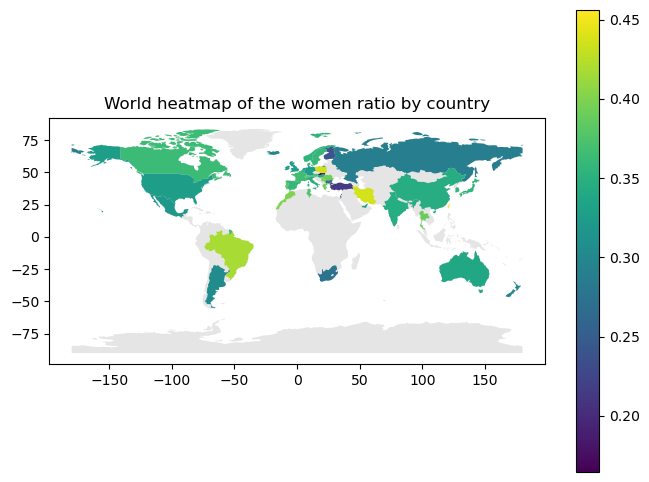

In [303]:
#get the world countries
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
plt.title("World heatmap of the women ratio by country")

#plot the countries in light gray
countries.plot(color="k", alpha=0.1, ax=ax)

#add the color in function of the women ratio
df = countries.merge(movie_gender_country.loc[movie_gender_country['count'] > 2].rename(columns={'countries' : 'name'}), on='name', how='inner')
gpd.GeoDataFrame(df).plot(column='women_ratio',ax=ax, legend=True) ;

Plot the women ratio by movie genres

In [304]:
genres = {"Action" : {"war", "military", "action", "spy", "espionage", "combat", "martial", "prison", "anti-war", "escape", "gangster", "escape", "heist", "epic"},
          "Comedy" : {"comedy", "fun", "parody"},
          "Horror" : {"horreur", "scary", "zombie"}, 
          "Science fiction" : {"space", "time", "science", "robot", "disaster", "apocalypse", "alien", "monster", "sci-fi", "fiction"},
          "Western" : {"western", "cowboy", "anti-western"},
          "Romance" : {"romance"},
          "Documentary" : {"society", "culture", "sport", "empire", "documentary", "sports"},
          "Thriller" : {"thriller", "spy", "conspiracy"},
          "Fantasy" : {"bangsian", "fantasy", "dark", "fables", "magic", "myth", "legends", "sorcery"},
          "Historical" : {"historical", "period", "history", "counterfactual"},
          "Crime" : {"detective", "crime", "murder", "mysteries", "enquete", "thief"},
          "Drama" : {"docudrama", "drama", "teen", "political", "melodrama", "issues"},
          "Animation" : {"animation", "motion", "stop", "claymation", "animated", "puppetry"},
          "Pornographic" : {"sex", "pornographic", "sexploitation", "erotica", "adult"}}

def regroup_genre(elements):
    for k,v in genres.items() :
        if len(elements.intersection(v)) :
            return k
    return pd.NaT

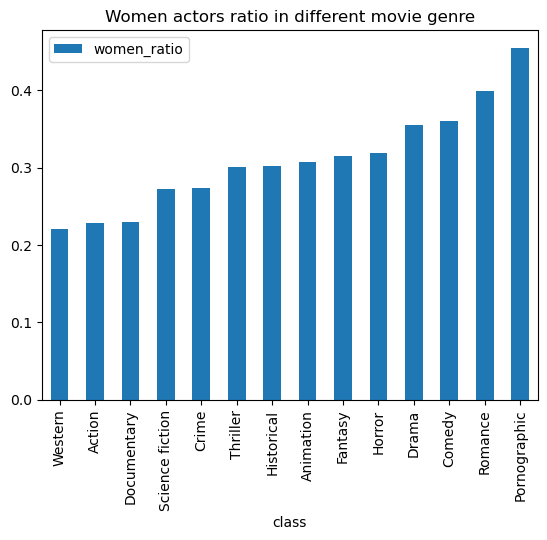

In [305]:
#make the subset by genres
movie_gender_genre = make_subset_gender_parity('genres')
movie_gender_genre = movie_gender_genre.loc[movie_gender_genre['count'] > 5]
movie_gender_genre['genres'] = movie_gender_genre['genres'].astype('str').apply(lambda x : set(x.lower().split()))

#apply the more general genre class
movie_gender_genre['class'] = movie_gender_genre['genres'].apply(regroup_genre)

# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=movie_gender_genre.loc[x.index, "count"])

movie_gender_genre = movie_gender_genre.dropna().groupby('class').agg(women_ratio=('women_ratio', wm))\
                    .sort_values(by='women_ratio')

#plot the graph
movie_gender_genre.plot(title='Women actors ratio in different movie genre', kind='bar') ;

# Milestone 2

Keep the code to reuse

# 2. Freebase database
Many features in our datasets have as format freebase ids. It is essential to be able to translate these features to their respective labels to properly understand our datasets and make precise analysis. This is why we made an auxiliary function to make queries to the freebase database.


### 2.1 Defining functions
We first define the `translate_freebase_list` function that returns a dict of freebase ID and its translations. Then define the `translate_freebase_df` function that we translate id for a full column on a dataframe.

In [306]:
def translate_freebase_list(freebase_ids) -> dict:
    """
    Uses queries to the wikidata database

    :param freebase_ids: list of string
    :return: dictionnary with id and it's translation
    """

    st = "\" \"".join(freebase_ids)
    st = "\"" + st + "\""

    query_content = """
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

    SELECT DISTINCT ?ISNI ?idLabel WHERE {
    VALUES ?ISNI {%s}
    ?id wdt:P646 ?ISNI
    SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
    }
    }
    """ % st

    query = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=" + urllib.parse.quote_plus(query_content)
    response = requests.get(query)
    if not response.ok :
        print("Error in request")
        return np.NaN

    values = response.json()
    if len(values) == 0 :
        return np.NaN

    return dict([(item['ISNI']['value'], item['idLabel']['value']) for item in values['results']['bindings']])

Definition of the `translate_freebase_df` function.

In [307]:
#split a list into n pieces
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

#add a translated column (of the col_name given) to the dataframe
def translate_freebase_df(df, col_name) :
    li = list(set(df[col_name].dropna().tolist()))
    di = dict()
    for l in split(li, 10) :
        di.update(translate_freebase_list(l))

    df[col_name + '_translated'] = df[col_name].apply(lambda x : di[x] if x in di else np.NaN)
    return df

### 2.2 Example
Below we run the `translate_freebase_df` on the characters metadata to retrieve their ethnicity.

In [308]:
translated_characters_df = character_metadata.copy()
translate_freebase_df(translated_characters_df, 'actor_ethnicity')

#print only rows where actor ethnicity is not null
translated_characters_df[['wikipedia_movie_id', 'actor_name', 'actor_ethnicity', 'actor_ethnicity_translated']].\
    loc[translated_characters_df['actor_ethnicity'].notna()].dropna().head(n=5)

,wikipedia_movie_id,actor_name,actor_ethnicity,actor_ethnicity_translated
2,975900,Ice Cube,/m/0x67,African Americans
5,975900,Pam Grier,/m/0x67,African Americans
11,975900,Rodney A. Grant,/m/064b9n,Omaha people
27,3196793,Albert Hall,/m/0x67,African Americans
55,2314463,Seth Green,/m/041rx,Jewish people


# 3. Initial observations

Let's begin with some analysis. For that we are going to need the ratio of women actors per movie.

In [309]:
movie_gender = character_metadata.groupby(['wikipedia_movie_id', 'actor_gender']).size().unstack(fill_value=0)
movie_gender['ratio'] = movie_gender['F'] / (movie_gender['M'] + movie_gender['F'])
movie_gender = movie_gender['ratio'].reset_index()

We are going to plot the ratio of female actors in movie over the years.

We can see that the ratio increases from 1940 to date but still remains below 0.37 which is intriguing. There is also an interesting period between 1920 and 1940 where the ratios are relatively high, it goes around 0.37, can we maybe link it to the particular history in those times ? We will continue those analysis in milestone 3.

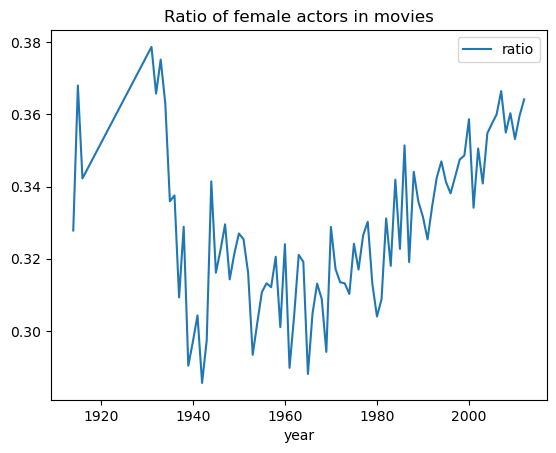

In [310]:
#merge the movie dates using wikipedia ids
movie_gender_date = pd.merge(movie_gender, movie_metadata[['wikipedia_movie_id', 'movie_release_date']], on='wikipedia_movie_id').dropna()
movie_gender_date['year'] = pd.DatetimeIndex(movie_gender_date['movie_release_date']).year.astype('int')

#group the movies by year and drop years with less than 275 movies
movie_gender_date = movie_gender_date[movie_gender_date.groupby('year')['year'].transform('size') >= 275].\
    groupby('year')['ratio'].mean().reset_index()

#plot the graph
movie_gender_date.plot(x='year', y='ratio', kind='line', title='Ratio of female actors in movies');


# 4. Additional dataset

One additional that we are going to use is the collection of the plot summaries, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref).

This dataset will be useful to help us understand the role of female characters in the different movies.

We are using the Element Tree module to parse the XML data.

In [311]:
DATA = '../corenlp_plot_summaries/'

def parse_nlp(id : str) -> ET :
    try:
        tree = ET.parse(DATA + id + '.xml')
        return tree.getroot()
    #It is quite common that some ids do not have a corresponding xml file
    except FileNotFoundError:
        return 'FileNotFoundError'

### 4.1 Example of the use of the core NLP

Let's see how useful the core NLP dataset can be useful

We use the core NLP dataset on the character Batman. We will collect information into the dictionary `batman_words` from all plot summaries of movies with the character batman.

In [312]:
#Let's get all the movies with batman
movies_with_batman = character_metadata['wikipedia_movie_id'].loc[character_metadata['character_name'] == 'Batman']


#Make a dic of all the words linked to Batman during the movies
batman_words = dict()

for id in movies_with_batman:

    #Get the element tree root from the xml file
    root = parse_nlp(str(id))

    #Some movies do not have a corresponding xml file
    if root != 'FileNotFoundError':
        #Add all words to the dictionary
        for dep in root.findall("document/sentences/sentence/basic-dependencies/dep/[dependent='Batman']"):
            type = dep.attrib['type']
            if type not in batman_words:
                batman_words[type] = set()
            batman_words[type].add(dep.find('governor').text)

#### Character connected

Spoiler alert ! We can see the connected characters to our batman in 'conj' (A conjunct is the relation between two elements connected by a conjunction word)
We obviously see the Jocker or Bruce as a connected characters

In [313]:
print("Character connected : " + str(batman_words['conj']))

Character connected : {'Owlman', 'Joker', 'Man', 'Bruce', 'Princess'}


#### Nominal subject
We can see Batman's actions using the nominal subject

In [314]:
print("Nominal subject : " + str(batman_words['nsubj']))

Nominal subject : {'throws', 'climb', 'promises', 'interrupting', 'expresses', 'says', 'responsible', 'has', 'comes', 'tries', 'made', 'stands', 'able', 'sneaks', 'rescues', 'decide', 'foils', 'gives', 'disarms', 'devises', 'tells', 'strikes', 'declines', 'continues', 'get', 'anticipated', 'believes', 'shows', 'replies', 'heartbroken', 'unhindered', 'recognizes', 'alter', 'tackles', 'interrupts', 'finds', 'intimidates', 'realizes', 'go', 'menace', 'lets', 'apprehends', 'stop', 'intercepts', 'disappeared', 'reveals', 'works', 'subdues', 'captures', 'asked', 'intervenes', 'confronts', 'engage', 'stays', 'manages', 'discovers', 'inoculates', 'stops', 'interrogates', 'pursues', 'attempts', 'win', 'takes', 'asks', 'thinks', 'locate', 'rushes', 'convinces', 'leaves', 'return', 'escapes', 'interrogate', 'uses', 'defends', 'appoints', 'outwits', 'Bat-Signal', 'hero', 'deduces', 'intends', 'destroys', 'arrives', 'knocks'}
